In [1]:
from numpy import unique
from numpy import nan
from numpy import array
from numpy import savetxt
from pandas import read_csv

from numpy import loadtxt
from numpy import nan
from numpy import isnan
from numpy import count_nonzero
from numpy import unique
from numpy import array
from numpy import nanmedian
from matplotlib import pyplot

In [2]:
def to_chunks(values, chunk_ix=1):
	chunks = dict()
	# get the unique chunk ids
	chunk_ids = unique(values[:, chunk_ix])
	# group rows by chunk id
	for chunk_id in chunk_ids:
		selection = values[:, chunk_ix] == chunk_id
		chunks[chunk_id] = values[selection, :]
	return chunks
 
# split each chunk into train/test sets
def split_train_test(chunks, row_in_chunk_ix=2):
	train, test = list(), list()
	# first 5 days of hourly observations for train
	cut_point = 5 * 24
	# enumerate chunks
	for k,rows in chunks.items():
		# split chunk rows by 'position_within_chunk'
		train_rows = rows[rows[:,row_in_chunk_ix] <= cut_point, :]
		test_rows = rows[rows[:,row_in_chunk_ix] > cut_point, :]
		if len(train_rows) == 0 or len(test_rows) == 0:
			print('>dropping chunk=%d: train=%s, test=%s' % (k, train_rows.shape, test_rows.shape))
			continue
		# store with chunk id, position in chunk, hour and all targets
		indices = [1,2,5] + [x for x in range(56,train_rows.shape[1])]
		train.append(train_rows[:, indices])
		test.append(test_rows[:, indices])
	return train, test

# return a list of relative forecast lead times
def get_lead_times():
	return [1, 2 ,3, 4, 5, 10, 17, 24, 48, 72]
 
# convert the rows in a test chunk to forecasts
def to_forecasts(test_chunks, row_in_chunk_ix=1):
	# get lead times
	lead_times = get_lead_times()
	# first 5 days of hourly observations for train
	cut_point = 5 * 24
	forecasts = list()
	# enumerate each chunk
	for rows in test_chunks:
		chunk_id = rows[0, 0]
		# enumerate each lead time
		for tau in lead_times:
			# determine the row in chunk we want for the lead time
			offset = cut_point + tau
			# retrieve data for the lead time using row number in chunk
			row_for_tau = rows[rows[:,row_in_chunk_ix]==offset, :]
			# check if we have data
			if len(row_for_tau) == 0:
				# create a mock row [chunk, position, hour] + [nan...]
				row = [chunk_id, offset, nan] + [nan for _ in range(39)]
				forecasts.append(row)
			else:
				# store the forecast row
				forecasts.append(row_for_tau[0])
	return array(forecasts)

In [4]:
dataset = read_csv('TrainingData.csv', header=0)
values = dataset.values
chunks = to_chunks(values)

In [8]:
train, test = split_train_test(chunks)
# flatten training chunks to rows
train_rows = array([row for rows in train for row in rows])
# print(train_rows.shape)
print('Train Rows: %s' % str(train_rows.shape))
# reduce train to forecast lead times only
test_rows = to_forecasts(test)
print('Test Rows: %s' % str(test_rows.shape))
# save datasets
savetxt('naive_train.csv', train_rows, delimiter=',')
savetxt('naive_test.csv', test_rows, delimiter=',')

>dropping chunk=69: train=(0, 95), test=(28, 95)
Train Rows: (23514, 42)
Test Rows: (2070, 42)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Local Median by Hour: [0.574 MAE] +1 0.561, +2 0.559, +3 0.568, +4 0.577, +5 0.577, +10 0.556, +17 0.551, +24 0.588, +48 0.601, +72 0.608


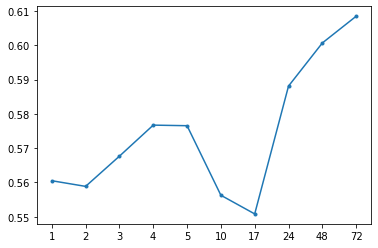

In [9]:
# split the dataset by 'chunkID', return a list of chunks
def to_chunks(values, chunk_ix=0):
	chunks = list()
	# get the unique chunk ids
	chunk_ids = unique(values[:, chunk_ix])
	# group rows by chunk id
	for chunk_id in chunk_ids:
		selection = values[:, chunk_ix] == chunk_id
		chunks.append(values[selection, :])
	return chunks
 
# return a list of relative forecast lead times
def get_lead_times():
	return [1, 2, 3, 4, 5, 10, 17, 24, 48, 72]
 
# forecast all lead times for one variable
def forecast_variable(train_chunks, chunk_train, chunk_test, lead_times, target_ix):
	forecast = list()
	# convert target number into column number
	col_ix = 3 + target_ix
	# enumerate lead times
	for i in range(len(lead_times)):
		# get the hour for this forecast lead time
		hour = chunk_test[i, 2]
		# check for no test data
		if isnan(hour):
			forecast.append(nan)
			continue
		# select rows in chunk with this hour
		selected = chunk_train[chunk_train[:,2]==hour]
		# calculate the central tendency for target
		value = nanmedian(selected[:, col_ix])
		forecast.append(value)
	return forecast
 
# forecast for each chunk, returns [chunk][variable][time]
def forecast_chunks(train_chunks, test_input):
	lead_times = get_lead_times()
	predictions = list()
	# enumerate chunks to forecast
	for i in range(len(train_chunks)):
		# enumerate targets for chunk
		chunk_predictions = list()
		for j in range(39):
			yhat = forecast_variable(train_chunks, train_chunks[i], test_input[i], lead_times, j)
			chunk_predictions.append(yhat)
		chunk_predictions = array(chunk_predictions)
		predictions.append(chunk_predictions)
	return array(predictions)
 
# convert the test dataset in chunks to [chunk][variable][time] format
def prepare_test_forecasts(test_chunks):
	predictions = list()
	# enumerate chunks to forecast
	for rows in test_chunks:
		# enumerate targets for chunk
		chunk_predictions = list()
		for j in range(3, rows.shape[1]):
			yhat = rows[:, j]
			chunk_predictions.append(yhat)
		chunk_predictions = array(chunk_predictions)
		predictions.append(chunk_predictions)
	return array(predictions)
 
# calculate the error between an actual and predicted value
def calculate_error(actual, predicted):
	# give the full actual value if predicted is nan
	if isnan(predicted):
		return abs(actual)
	# calculate abs difference
	return abs(actual - predicted)
 
# evaluate a forecast in the format [chunk][variable][time]
def evaluate_forecasts(predictions, testset):
	lead_times = get_lead_times()
	total_mae, times_mae = 0.0, [0.0 for _ in range(len(lead_times))]
	total_c, times_c = 0, [0 for _ in range(len(lead_times))]
	# enumerate test chunks
	for i in range(len(test_chunks)):
		# convert to forecasts
		actual = testset[i]
		predicted = predictions[i]
		# enumerate target variables
		for j in range(predicted.shape[0]):
			# enumerate lead times
			for k in range(len(lead_times)):
				# skip if actual in nan
				if isnan(actual[j, k]):
					continue
				# calculate error
				error = calculate_error(actual[j, k], predicted[j, k])
				# update statistics
				total_mae += error
				times_mae[k] += error
				total_c += 1
				times_c[k] += 1
	# normalize summed absolute errors
	total_mae /= total_c
	times_mae = [times_mae[i]/times_c[i] for i in range(len(times_mae))]
	return total_mae, times_mae
 
# summarize scores
def summarize_error(name, total_mae, times_mae):
	# print summary
	lead_times = get_lead_times()
	formatted = ['+%d %.3f' % (lead_times[i], times_mae[i]) for i in range(len(lead_times))]
	s_scores = ', '.join(formatted)
	print('%s: [%.3f MAE] %s' % (name, total_mae, s_scores))
	# plot summary
	pyplot.plot([str(x) for x in lead_times], times_mae, marker='.')
	pyplot.show()
 
# load dataset
train = loadtxt('naive_train.csv', delimiter=',')
test = loadtxt('naive_test.csv', delimiter=',')
# group data by chunks
train_chunks = to_chunks(train)
test_chunks = to_chunks(test)
# forecast
test_input = [rows[:, :3] for rows in test_chunks]
forecast = forecast_chunks(train_chunks, test_input)
# evaluate forecast
actual = prepare_test_forecasts(test_chunks)
total_mae, times_mae = evaluate_forecasts(forecast, actual)
# summarize forecast
summarize_error('Local Median by Hour', total_mae, times_mae)

In [10]:
# layout a variable with breaks in the data for missing positions
def variable_to_series(chunk_train, col_ix, n_steps=5*24):
	# lay out whole series
	data = [nan for _ in range(n_steps)]
	# mark all available data
	for i in range(len(chunk_train)):
		# get position in chunk
		position = int(chunk_train[i, 1] - 1)
		# store data
		data[position] = chunk_train[i, col_ix]
	return data

In [11]:
# interpolate series of hours (in place) in 24 hour time
def interpolate_hours(hours):
	# find the first hour
	ix = -1
	for i in range(len(hours)):
		if not isnan(hours[i]):
			ix = i
			break
	# fill-forward
	hour = hours[ix]
	for i in range(ix+1, len(hours)):
		# increment hour
		hour += 1
		# check for a fill
		if isnan(hours[i]):
			hours[i] = hour % 24
	# fill-backward
	hour = hours[ix]
	for i in range(ix-1, -1, -1):
		# decrement hour
		hour -= 1
		# check for a fill
		if isnan(hours[i]):
			hours[i] = hour % 24

In [14]:
# prepare sequence of hours for the chunk
hours = variable_to_series(train, 2)
# interpolate hours
interpolate_hours(hours)

In [15]:
# impute missing data
def impute_missing(train_chunks, rows, hours, series, col_ix):
	# impute missing using the median value for hour in all series
	imputed = list()
	for i in range(len(series)):
		if isnan(series[i]):
			# collect all rows across all chunks for the hour
			all_rows = list()
			for rows in train_chunks:
				[all_rows.append(row) for row in rows[rows[:,2]==hours[i]]]
			# calculate the central tendency for target
			all_rows = array(all_rows)
			# fill with median value
			value = nanmedian(all_rows[:, col_ix])
			if isnan(value):
				value = 0.0
			imputed.append(value)
		else:
			imputed.append(series[i])
	return imputed

In [17]:
# created input/output patterns from a sequence
def supervised_for_lead_time(series, n_lag, lead_time):
	samples = list()
	# enumerate observations and create input/output patterns
	for i in range(n_lag, len(series)):
		end_ix = i + (lead_time - 1)
		# check if can create a pattern
		if end_ix >= len(series):
			break
		# retrieve input and output
		start_ix = i - n_lag
		row = series[start_ix:i] + [series[end_ix]]
		samples.append(row)
	return samples

In [18]:
# test supervised to input/output patterns
from numpy import array

# created input/output patterns from a sequence
def supervised_for_lead_time(series, n_lag, lead_time):
	data = list()
	# enumerate observations and create input/output patterns
	for i in range(n_lag, len(series)):
		end_ix = i + (lead_time - 1)
		# check if can create a pattern
		if end_ix >= len(series):
			break
		# retrieve input and output
		start_ix = i - n_lag
		row = series[start_ix:i] + [series[end_ix]]
		data.append(row)
	return array(data)

# define test dataset
data = [x for x in range(20)]
# convert to supervised format
result = supervised_for_lead_time(data, 2, 6)
# display result
print(result)

[[ 0  1  7]
 [ 1  2  8]
 [ 2  3  9]
 [ 3  4 10]
 [ 4  5 11]
 [ 5  6 12]
 [ 6  7 13]
 [ 7  8 14]
 [ 8  9 15]
 [ 9 10 16]
 [10 11 17]
 [11 12 18]
 [12 13 19]]


In [19]:
# create supervised learning data for each lead time for this target
def target_to_supervised(chunks, rows, hours, col_ix, n_lag):
	train_lead_times = list()
	# get series
	series = variable_to_series(rows, col_ix)
	if not has_data(series):
		return None, [nan for _ in range(n_lag)]
	# impute
	imputed = impute_missing(chunks, rows, hours, series, col_ix)
	# prepare test sample for chunk-variable
	test_sample = array(imputed[-n_lag:])
	# enumerate lead times
	lead_times = get_lead_times()
	for lead_time in lead_times:
		# make input/output data from series
		train_samples = supervised_for_lead_time(imputed, n_lag, lead_time)
		train_lead_times.append(train_samples)
	return train_lead_times, test_sample

In [20]:
# prepare training [var][lead time][sample] and test [chunk][var][sample]
def data_prep(chunks, n_lag, n_vars=39):
	lead_times = get_lead_times()
	train_data = [[list() for _ in range(len(lead_times))] for _ in range(n_vars)]
	test_data = [[list() for _ in range(n_vars)] for _ in range(len(chunks))]
	# enumerate targets for chunk
	for var in range(n_vars):
		# convert target number into column number
		col_ix = 3 + var
		# enumerate chunks to forecast
		for c_id in range(len(chunks)):
			rows = chunks[c_id]
			# prepare sequence of hours for the chunk
			hours = variable_to_series(rows, 2)
			# interpolate hours
			interpolate_hours(hours)
			# check for no data
			if not has_data(rows[:, col_ix]):
				continue
			# convert series into training data for each lead time
			train, test_sample = target_to_supervised(chunks, rows, hours, col_ix, n_lag)
			# store test sample for this var-chunk
			test_data[c_id][var] = test_sample
			if train is not None:
				# store samples per lead time
				for lead_time in range(len(lead_times)):
					# add all rows to the existing list of rows
					train_data[var][lead_time].extend(train[lead_time])
		# convert all rows for each var-lead time to a numpy array
		for lead_time in range(len(lead_times)):
			train_data[var][lead_time] = array(train_data[var][lead_time])
	return array(train_data), array(test_data)

In [21]:
# prepare data
from numpy import loadtxt
from numpy import nan
from numpy import isnan
from numpy import count_nonzero
from numpy import unique
from numpy import array
from numpy import nanmedian
from numpy import save

# split the dataset by 'chunkID', return a list of chunks
def to_chunks(values, chunk_ix=0):
	chunks = list()
	# get the unique chunk ids
	chunk_ids = unique(values[:, chunk_ix])
	# group rows by chunk id
	for chunk_id in chunk_ids:
		selection = values[:, chunk_ix] == chunk_id
		chunks.append(values[selection, :])
	return chunks

# return a list of relative forecast lead times
def get_lead_times():
	return [1, 2, 3, 4, 5, 10, 17, 24, 48, 72]

# interpolate series of hours (in place) in 24 hour time
def interpolate_hours(hours):
	# find the first hour
	ix = -1
	for i in range(len(hours)):
		if not isnan(hours[i]):
			ix = i
			break
	# fill-forward
	hour = hours[ix]
	for i in range(ix+1, len(hours)):
		# increment hour
		hour += 1
		# check for a fill
		if isnan(hours[i]):
			hours[i] = hour % 24
	# fill-backward
	hour = hours[ix]
	for i in range(ix-1, -1, -1):
		# decrement hour
		hour -= 1
		# check for a fill
		if isnan(hours[i]):
			hours[i] = hour % 24

# return true if the array has any non-nan values
def has_data(data):
	return count_nonzero(isnan(data)) < len(data)

# impute missing data
def impute_missing(train_chunks, rows, hours, series, col_ix):
	# impute missing using the median value for hour in all series
	imputed = list()
	for i in range(len(series)):
		if isnan(series[i]):
			# collect all rows across all chunks for the hour
			all_rows = list()
			for rows in train_chunks:
				[all_rows.append(row) for row in rows[rows[:,2]==hours[i]]]
			# calculate the central tendency for target
			all_rows = array(all_rows)
			# fill with median value
			value = nanmedian(all_rows[:, col_ix])
			if isnan(value):
				value = 0.0
			imputed.append(value)
		else:
			imputed.append(series[i])
	return imputed

# layout a variable with breaks in the data for missing positions
def variable_to_series(chunk_train, col_ix, n_steps=5*24):
	# lay out whole series
	data = [nan for _ in range(n_steps)]
	# mark all available data
	for i in range(len(chunk_train)):
		# get position in chunk
		position = int(chunk_train[i, 1] - 1)
		# store data
		data[position] = chunk_train[i, col_ix]
	return data

# created input/output patterns from a sequence
def supervised_for_lead_time(series, n_lag, lead_time):
	samples = list()
	# enumerate observations and create input/output patterns
	for i in range(n_lag, len(series)):
		end_ix = i + (lead_time - 1)
		# check if can create a pattern
		if end_ix >= len(series):
			break
		# retrieve input and output
		start_ix = i - n_lag
		row = series[start_ix:i] + [series[end_ix]]
		samples.append(row)
	return samples

# create supervised learning data for each lead time for this target
def target_to_supervised(chunks, rows, hours, col_ix, n_lag):
	train_lead_times = list()
	# get series
	series = variable_to_series(rows, col_ix)
	if not has_data(series):
		return None, [nan for _ in range(n_lag)]
	# impute
	imputed = impute_missing(chunks, rows, hours, series, col_ix)
	# prepare test sample for chunk-variable
	test_sample = array(imputed[-n_lag:])
	# enumerate lead times
	lead_times = get_lead_times()
	for lead_time in lead_times:
		# make input/output data from series
		train_samples = supervised_for_lead_time(imputed, n_lag, lead_time)
		train_lead_times.append(train_samples)
	return train_lead_times, test_sample

# prepare training [var][lead time][sample] and test [chunk][var][sample]
def data_prep(chunks, n_lag, n_vars=39):
	lead_times = get_lead_times()
	train_data = [[list() for _ in range(len(lead_times))] for _ in range(n_vars)]
	test_data = [[list() for _ in range(n_vars)] for _ in range(len(chunks))]
	# enumerate targets for chunk
	for var in range(n_vars):
		# convert target number into column number
		col_ix = 3 + var
		# enumerate chunks to forecast
		for c_id in range(len(chunks)):
			rows = chunks[c_id]
			# prepare sequence of hours for the chunk
			hours = variable_to_series(rows, 2)
			# interpolate hours
			interpolate_hours(hours)
			# check for no data
			if not has_data(rows[:, col_ix]):
				continue
			# convert series into training data for each lead time
			train, test_sample = target_to_supervised(chunks, rows, hours, col_ix, n_lag)
			# store test sample for this var-chunk
			test_data[c_id][var] = test_sample
			if train is not None:
				# store samples per lead time
				for lead_time in range(len(lead_times)):
					# add all rows to the existing list of rows
					train_data[var][lead_time].extend(train[lead_time])
		# convert all rows for each var-lead time to a numpy array
		for lead_time in range(len(lead_times)):
			train_data[var][lead_time] = array(train_data[var][lead_time])
	return array(train_data), array(test_data)

# load dataset
train = loadtxt('naive_train.csv', delimiter=',')
test = loadtxt('naive_test.csv', delimiter=',')
# group data by chunks
train_chunks = to_chunks(train)
test_chunks = to_chunks(test)
# convert training data into supervised learning data
n_lag = 12
train_data, test_data = data_prep(train_chunks, n_lag)
print(train_data.shape, test_data.shape)
# save train and test sets to file
save('supervised_train.npy', train_data)
save('supervised_test.npy', test_data)

<ipython-input-21-5d74a91afad8>:153: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(train_data), array(test_data)


(39, 10) (207, 39)


In [22]:
# fit a single model
def fit_model(model, X, y):
	# clone the model configuration
	local_model = clone(model)
	# fit the model
	local_model.fit(X, y)
	return local_model

In [23]:
# fit one model for each variable and each forecast lead time [var][time][model]
def fit_models(model, train):
	# prepare structure for saving models
	models = [[list() for _ in range(train.shape[1])] for _ in range(train.shape[0])]
	# enumerate vars
	for i in range(train.shape[0]):
		# enumerate lead times
		for j in range(train.shape[1]):
			# get data
			data = train[i, j]
			X, y = data[:, :-1], data[:, -1]
			# fit model
			local_model = fit_model(model, X, y)
			models[i][j].append(local_model)
	return models

In [24]:
# return forecasts as [chunks][var][time]
def make_predictions(models, test):
	lead_times = get_lead_times()
	predictions = list()
	# enumerate chunks
	for i in range(test.shape[0]):
		# enumerate variables
		chunk_predictions = list()
		for j in range(test.shape[1]):
			# get the input pattern for this chunk and target
			pattern = test[i,j]
			# assume a nan forecast
			forecasts = array([nan for _ in range(len(lead_times))])
			# check we can make a forecast
			if has_data(pattern):
				pattern = pattern.reshape((1, len(pattern)))
				# forecast each lead time
				forecasts = list()
				for k in range(len(lead_times)):
					yhat = models[j][k][0].predict(pattern)
					forecasts.append(yhat[0])
				forecasts = array(forecasts)
			# save forecasts fore each lead time for this variable
			chunk_predictions.append(forecasts)
		# save forecasts for this chunk
		chunk_predictions = array(chunk_predictions)
		predictions.append(chunk_predictions)
	return array(predictions)

In [25]:
# prepare a list of ml models
def get_models(models=dict()):
	# ...
	return models

In [26]:
# evaluate a suite of models
def evaluate_models(models, train, test, actual):
	for name, model in models.items():
		# fit models
		fits = fit_models(model, train)
		# make predictions
		predictions = make_predictions(fits, test)
		# evaluate forecast
		total_mae, _ = evaluate_forecasts(predictions, actual)
		# summarize forecast
		summarize_error(name, total_mae)

In [27]:
# prepare a list of ml models
def get_models(models=dict()):
	# linear models
	models['lr'] = LinearRegression()
	models['lasso'] = Lasso()
	models['ridge'] = Ridge()
	models['en'] = ElasticNet()
	models['huber'] = HuberRegressor()
	models['llars'] = LassoLars()
	models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
	models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
	print('Defined %d models' % len(models))
	return models

In [28]:
# evaluate linear algorithms
from numpy import load
from numpy import loadtxt
from numpy import nan
from numpy import isnan
from numpy import count_nonzero
from numpy import unique
from numpy import array
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor

# split the dataset by 'chunkID', return a list of chunks
def to_chunks(values, chunk_ix=0):
	chunks = list()
	# get the unique chunk ids
	chunk_ids = unique(values[:, chunk_ix])
	# group rows by chunk id
	for chunk_id in chunk_ids:
		selection = values[:, chunk_ix] == chunk_id
		chunks.append(values[selection, :])
	return chunks

# return true if the array has any non-nan values
def has_data(data):
	return count_nonzero(isnan(data)) < len(data)

# return a list of relative forecast lead times
def get_lead_times():
	return [1, 2, 3, 4, 5, 10, 17, 24, 48, 72]

# fit a single model
def fit_model(model, X, y):
	# clone the model configuration
	local_model = clone(model)
	# fit the model
	local_model.fit(X, y)
	return local_model

# fit one model for each variable and each forecast lead time [var][time][model]
def fit_models(model, train):
	# prepare structure for saving models
	models = [[list() for _ in range(train.shape[1])] for _ in range(train.shape[0])]
	# enumerate vars
	for i in range(train.shape[0]):
		# enumerate lead times
		for j in range(train.shape[1]):
			# get data
			data = train[i, j]
			X, y = data[:, :-1], data[:, -1]
			# fit model
			local_model = fit_model(model, X, y)
			models[i][j].append(local_model)
	return models

# return forecasts as [chunks][var][time]
def make_predictions(models, test):
	lead_times = get_lead_times()
	predictions = list()
	# enumerate chunks
	for i in range(test.shape[0]):
		# enumerate variables
		chunk_predictions = list()
		for j in range(test.shape[1]):
			# get the input pattern for this chunk and target
			pattern = test[i,j]
			# assume a nan forecast
			forecasts = array([nan for _ in range(len(lead_times))])
			# check we can make a forecast
			if has_data(pattern):
				pattern = pattern.reshape((1, len(pattern)))
				# forecast each lead time
				forecasts = list()
				for k in range(len(lead_times)):
					yhat = models[j][k][0].predict(pattern)
					forecasts.append(yhat[0])
				forecasts = array(forecasts)
			# save forecasts for each lead time for this variable
			chunk_predictions.append(forecasts)
		# save forecasts for this chunk
		chunk_predictions = array(chunk_predictions)
		predictions.append(chunk_predictions)
	return array(predictions)

# convert the test dataset in chunks to [chunk][variable][time] format
def prepare_test_forecasts(test_chunks):
	predictions = list()
	# enumerate chunks to forecast
	for rows in test_chunks:
		# enumerate targets for chunk
		chunk_predictions = list()
		for j in range(3, rows.shape[1]):
			yhat = rows[:, j]
			chunk_predictions.append(yhat)
		chunk_predictions = array(chunk_predictions)
		predictions.append(chunk_predictions)
	return array(predictions)

# calculate the error between an actual and predicted value
def calculate_error(actual, predicted):
	# give the full actual value if predicted is nan
	if isnan(predicted):
		return abs(actual)
	# calculate abs difference
	return abs(actual - predicted)

# evaluate a forecast in the format [chunk][variable][time]
def evaluate_forecasts(predictions, testset):
	lead_times = get_lead_times()
	total_mae, times_mae = 0.0, [0.0 for _ in range(len(lead_times))]
	total_c, times_c = 0, [0 for _ in range(len(lead_times))]
	# enumerate test chunks
	for i in range(len(test_chunks)):
		# convert to forecasts
		actual = testset[i]
		predicted = predictions[i]
		# enumerate target variables
		for j in range(predicted.shape[0]):
			# enumerate lead times
			for k in range(len(lead_times)):
				# skip if actual in nan
				if isnan(actual[j, k]):
					continue
				# calculate error
				error = calculate_error(actual[j, k], predicted[j, k])
				# update statistics
				total_mae += error
				times_mae[k] += error
				total_c += 1
				times_c[k] += 1
	# normalize summed absolute errors
	total_mae /= total_c
	times_mae = [times_mae[i]/times_c[i] for i in range(len(times_mae))]
	return total_mae, times_mae

# summarize scores
def summarize_error(name, total_mae):
	print('%s: %.3f MAE' % (name, total_mae))

# prepare a list of ml models
def get_models(models=dict()):
	# linear models
	models['lr'] = LinearRegression()
	models['lasso'] = Lasso()
	models['ridge'] = Ridge()
	models['en'] = ElasticNet()
	models['huber'] = HuberRegressor()
	models['llars'] = LassoLars()
	models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
	models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
	print('Defined %d models' % len(models))
	return models

# evaluate a suite of models
def evaluate_models(models, train, test, actual):
	for name, model in models.items():
		# fit models
		fits = fit_models(model, train)
		# make predictions
		predictions = make_predictions(fits, test)
		# evaluate forecast
		total_mae, _ = evaluate_forecasts(predictions, actual)
		# summarize forecast
		summarize_error(name, total_mae)

# load supervised datasets
train = load('supervised_train.npy', allow_pickle=True)
test = load('supervised_test.npy', allow_pickle=True)
print(train.shape, test.shape)
# load test chunks for validation
testset = loadtxt('naive_test.csv', delimiter=',')
test_chunks = to_chunks(testset)
actual = prepare_test_forecasts(test_chunks)
# prepare list of models
models = get_models()
# evaluate models
evaluate_models(models, train, test, actual)

(39, 10) (207, 39)
Defined 8 models
lr: 0.454 MAE
lasso: 0.624 MAE
ridge: 0.454 MAE
en: 0.595 MAE


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

huber: 0.434 MAE


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproc

llars: 0.631 MAE
pa: 0.820 MAE
sgd: 0.458 MAE


In [29]:
# prepare a list of ml models
def get_models(models=dict()):
	# non-linear models
	models['knn'] = KNeighborsRegressor(n_neighbors=7)
	models['cart'] = DecisionTreeRegressor()
	models['extra'] = ExtraTreeRegressor()
	models['svmr'] = SVR()
	# # ensemble models
	n_trees = 100
	models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
	models['bag'] = BaggingRegressor(n_estimators=n_trees)
	models['rf'] = RandomForestRegressor(n_estimators=n_trees)
	models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
	models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models

In [ ]:
# spot check nonlinear algorithms
from numpy import load
from numpy import loadtxt
from numpy import nan
from numpy import isnan
from numpy import count_nonzero
from numpy import unique
from numpy import array
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

# split the dataset by 'chunkID', return a list of chunks
def to_chunks(values, chunk_ix=0):
	chunks = list()
	# get the unique chunk ids
	chunk_ids = unique(values[:, chunk_ix])
	# group rows by chunk id
	for chunk_id in chunk_ids:
		selection = values[:, chunk_ix] == chunk_id
		chunks.append(values[selection, :])
	return chunks

# return true if the array has any non-nan values
def has_data(data):
	return count_nonzero(isnan(data)) < len(data)

# return a list of relative forecast lead times
def get_lead_times():
	return [1, 2, 3, 4, 5, 10, 17, 24, 48, 72]

# fit a single model
def fit_model(model, X, y):
	# clone the model configuration
	local_model = clone(model)
	# fit the model
	local_model.fit(X, y)
	return local_model

# fit one model for each variable and each forecast lead time [var][time][model]
def fit_models(model, train):
	# prepare structure for saving models
	models = [[list() for _ in range(train.shape[1])] for _ in range(train.shape[0])]
	# enumerate vars
	for i in range(train.shape[0]):
		# enumerate lead times
		for j in range(train.shape[1]):
			# get data
			data = train[i, j]
			X, y = data[:, :-1], data[:, -1]
			# fit model
			local_model = fit_model(model, X, y)
			models[i][j].append(local_model)
	return models

# return forecasts as [chunks][var][time]
def make_predictions(models, test):
	lead_times = get_lead_times()
	predictions = list()
	# enumerate chunks
	for i in range(test.shape[0]):
		# enumerate variables
		chunk_predictions = list()
		for j in range(test.shape[1]):
			# get the input pattern for this chunk and target
			pattern = test[i,j]
			# assume a nan forecast
			forecasts = array([nan for _ in range(len(lead_times))])
			# check we can make a forecast
			if has_data(pattern):
				pattern = pattern.reshape((1, len(pattern)))
				# forecast each lead time
				forecasts = list()
				for k in range(len(lead_times)):
					yhat = models[j][k][0].predict(pattern)
					forecasts.append(yhat[0])
				forecasts = array(forecasts)
			# save forecasts for each lead time for this variable
			chunk_predictions.append(forecasts)
		# save forecasts for this chunk
		chunk_predictions = array(chunk_predictions)
		predictions.append(chunk_predictions)
	return array(predictions)

# convert the test dataset in chunks to [chunk][variable][time] format
def prepare_test_forecasts(test_chunks):
	predictions = list()
	# enumerate chunks to forecast
	for rows in test_chunks:
		# enumerate targets for chunk
		chunk_predictions = list()
		for j in range(3, rows.shape[1]):
			yhat = rows[:, j]
			chunk_predictions.append(yhat)
		chunk_predictions = array(chunk_predictions)
		predictions.append(chunk_predictions)
	return array(predictions)

# calculate the error between an actual and predicted value
def calculate_error(actual, predicted):
	# give the full actual value if predicted is nan
	if isnan(predicted):
		return abs(actual)
	# calculate abs difference
	return abs(actual - predicted)

# evaluate a forecast in the format [chunk][variable][time]
def evaluate_forecasts(predictions, testset):
	lead_times = get_lead_times()
	total_mae, times_mae = 0.0, [0.0 for _ in range(len(lead_times))]
	total_c, times_c = 0, [0 for _ in range(len(lead_times))]
	# enumerate test chunks
	for i in range(len(test_chunks)):
		# convert to forecasts
		actual = testset[i]
		predicted = predictions[i]
		# enumerate target variables
		for j in range(predicted.shape[0]):
			# enumerate lead times
			for k in range(len(lead_times)):
				# skip if actual in nan
				if isnan(actual[j, k]):
					continue
				# calculate error
				error = calculate_error(actual[j, k], predicted[j, k])
				# update statistics
				total_mae += error
				times_mae[k] += error
				total_c += 1
				times_c[k] += 1
	# normalize summed absolute errors
	total_mae /= total_c
	times_mae = [times_mae[i]/times_c[i] for i in range(len(times_mae))]
	return total_mae, times_mae

# summarize scores
def summarize_error(name, total_mae):
	print('%s: %.3f MAE' % (name, total_mae))

# prepare a list of ml models
def get_models(models=dict()):
	# non-linear models
	models['knn'] = KNeighborsRegressor(n_neighbors=7)
	models['cart'] = DecisionTreeRegressor()
	models['extra'] = ExtraTreeRegressor()
	models['svmr'] = SVR()
	# # ensemble models
	n_trees = 100
	models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
	models['bag'] = BaggingRegressor(n_estimators=n_trees)
	models['rf'] = RandomForestRegressor(n_estimators=n_trees)
	models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
	models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models

# evaluate a suite of models
def evaluate_models(models, train, test, actual):
	for name, model in models.items():
		# fit models
		fits = fit_models(model, train)
		# make predictions
		predictions = make_predictions(fits, test)
		# evaluate forecast
		total_mae, _ = evaluate_forecasts(predictions, actual)
		# summarize forecast
		summarize_error(name, total_mae)

# load supervised datasets
train = load('supervised_train.npy', allow_pickle=True)
test = load('supervised_test.npy', allow_pickle=True)
print(train.shape, test.shape)
# load test chunks for validation
testset = loadtxt('naive_test.csv', delimiter=',')
test_chunks = to_chunks(testset)
actual = prepare_test_forecasts(test_chunks)
# prepare list of models
models = get_models()
# evaluate models
evaluate_models(models, train, test, actual)

(39, 10) (207, 39)
Defined 9 models
knn: 0.485 MAE
cart: 0.634 MAE
extra: 0.626 MAE
